# Using GraSPI

## Reproduce Previous Work

This notebook reproduces [an analysis from the original GraSPI package](https://github.com/owodolab/graspi/blob/ede5c1625cc95da438a3ba6e06291f8e0fd1c68b/examples/2phaseMorphologies/thinFilm/Report.pdf). The microstructure is generated by a Cahn-Hilliard simulation. The graph statistics are designed to characterize a photo-voltaic device. The upper boundary is an anode and the bottom boundary is a cathode. The yellow material is donor while the blue material is acceptor.

In [1]:
import numpy as np
import pandas
from pymks import plot_microstructures
from pymks import graph_descriptors

In [2]:
data = np.array(pandas.read_csv('data_0.528_3.8_000160.txt', delimiter=' ', header=None)).swapaxes(0, 1)

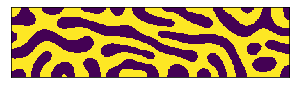

In [3]:
plot_microstructures(data.swapaxes(0, 1), colorbar=False)

In [4]:
data.shape

(401, 101)

In [5]:
graph_descriptors(data[None])

,n_vertices,n_edges,n_phase0,n_phase1,n_phase0_connect,n_phase1_connect,n_phase0_connect_top,n_phase1_connect_bottom,w_frac_phase0,frac_phase0,w_frac_phase0_10_dist,fraction_phase0_10_dist,inter_frac_bottom_and_top,frac_phase0_top,frac_phase1_bottom,n_inter_paths,n_phase0_inter_top,n_phase1_inter_bottom,frac_phase0_rising,frac_phase1_rising
0,40501,3698,19268,21233,22,5,9,3,0.298392,0.475741,0.617915,0.991956,0.296376,0.319545,0.979843,1096,1159,3668,0.522495,0.152944
